In [1]:
import pandas as pd
import numpy as np
import datetime as dt

import plotly.graph_objs as go
import plotly.figure_factory as ff
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot

init_notebook_mode(connected=True)

import torch
from torch import nn
from torch.autograd import Variable
from torch.utils.data import DataLoader
from torch import optim
from torch.optim import lr_scheduler
import numpy as np
import matplotlib.pyplot as plt


from torch.utils.data.dataset import Dataset


## Loading data into data_loader form

In [14]:
"""
This is the way Pytorch reads data, class like a container
which takes data then returns data and labels
"""     
class My_dataset(Dataset):
    def __init__(self, csv_path):
        self.data_info = pd.read_csv(csv_path,header=None)
        self.data = np.asarray(self.data_info.iloc[:,1:7], dtype=np.float64)
        self.label = np.asarray(self.data_info.iloc[:,7], dtype=np.float64)
        self.data_len = len(self.data_info.index)
        
    def __getitem__(self, index):
        single_row = self.data[index]
        row = torch.FloatTensor(single_row)
        target = torch.from_numpy(np.array(self.label[index]) )
        return (row, target)
    def __len__(self):
        return self.data_len
     

## LSTM class

In [48]:
class LSTM(nn.Module):
    def __init__(self, hidden_size=64, hidden_size2=128, dropout=0.2, n_layers=4):

        super(LSTM, self).__init__()
        self.hidden_size = hidden_size
        self.hidden_size2 = hidden_size2
        self.rnn = nn.LSTM(
            input_size=1,
            hidden_size=self.hidden_size,
            num_layers=n_layers,
            dropout=dropout,
            bidirectional=False
        )

        self.fc1 = nn.Linear(self.hidden_size, self.hidden_size)
        self.fc1.weight.data.normal_()
        self.fc2 = nn.Linear(self.hidden_size, 10)
        self.fc3 = nn.Linear(10, 1)
        self.relu = nn.ReLU()
        self.T = T

    def forward(self, x):

        batch_size = x.size()[1]
        seq_length = x.size()[0]
        x = x.view(seq_length, batch_size, -1)  # making it (seq_length * batch * 1)
        # Initial cell states
        h0 = Variable(torch.zeros(self.rnn.num_layers, batch_size, self.hidden_size)).cuda()
        c0 = Variable(torch.zeros(self.rnn.num_layers, batch_size, self.hidden_size)).cuda()
        outputs, (ht, ct) = self.rnn(x, (h0, c0))
        out = outputs[-1]  # get last element(prediction)
        out = self.fc1(out)
        out = self.fc2(out)
        out = self.relu(out)
        out = self.fc3(out)
        
        return out

## Run

/home/eslam/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:52: UserWarning:

invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number



Epoch number: 0
the Loss of the current epoch: tensor(7.8984, device='cuda:0')


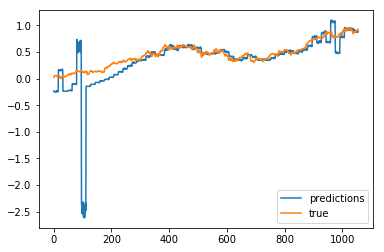

Epoch number: 1
the Loss of the current epoch: tensor(1.0620, device='cuda:0')
Epoch number: 2
the Loss of the current epoch: tensor(1.1137, device='cuda:0')
Epoch number: 3
the Loss of the current epoch: tensor(1.1197, device='cuda:0')
Epoch number: 4
the Loss of the current epoch: tensor(1.1248, device='cuda:0')
Epoch number: 5
the Loss of the current epoch: tensor(1.0854, device='cuda:0')
Epoch number: 6
the Loss of the current epoch: tensor(1.0179, device='cuda:0')
Epoch number: 7
the Loss of the current epoch: tensor(0.7820, device='cuda:0')
Epoch number: 8
the Loss of the current epoch: tensor(0.5863, device='cuda:0')
Epoch number: 9
the Loss of the current epoch: tensor(0.7226, device='cuda:0')
Epoch number: 10
the Loss of the current epoch: tensor(0.3539, device='cuda:0')
Epoch number: 11
the Loss of the current epoch: tensor(0.3154, device='cuda:0')
Epoch number: 12
the Loss of the current epoch: tensor(0.3659, device='cuda:0')
Epoch number: 13
the Loss of the current epoch: t

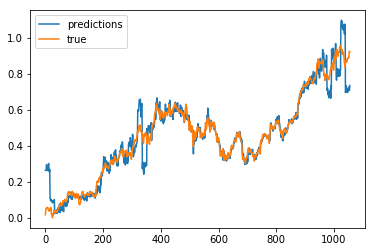

Epoch number: 31
the Loss of the current epoch: tensor(0.2239, device='cuda:0')
Epoch number: 32
the Loss of the current epoch: tensor(0.1393, device='cuda:0')
Epoch number: 33
the Loss of the current epoch: tensor(0.2906, device='cuda:0')
Epoch number: 34
the Loss of the current epoch: tensor(0.2347, device='cuda:0')
Epoch number: 35
the Loss of the current epoch: tensor(0.1960, device='cuda:0')
Epoch number: 36
the Loss of the current epoch: tensor(0.2544, device='cuda:0')
Epoch number: 37
the Loss of the current epoch: tensor(0.1825, device='cuda:0')
Epoch number: 38
the Loss of the current epoch: tensor(0.1786, device='cuda:0')
Epoch number: 39
the Loss of the current epoch: tensor(0.1608, device='cuda:0')
Epoch number: 40
the Loss of the current epoch: tensor(0.1836, device='cuda:0')
Epoch number: 41
the Loss of the current epoch: tensor(0.2242, device='cuda:0')
Epoch number: 42
the Loss of the current epoch: tensor(0.2132, device='cuda:0')
Epoch number: 43
the Loss of the current

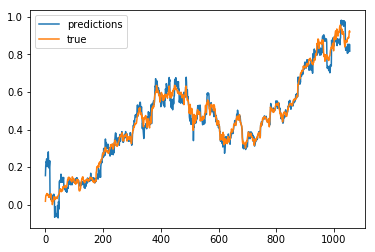

Epoch number: 61
the Loss of the current epoch: tensor(0.1034, device='cuda:0')
Epoch number: 62
the Loss of the current epoch: tensor(0.1664, device='cuda:0')
Epoch number: 63
the Loss of the current epoch: tensor(0.1148, device='cuda:0')
Epoch number: 64
the Loss of the current epoch: tensor(0.1698, device='cuda:0')
Epoch number: 65
the Loss of the current epoch: tensor(0.1260, device='cuda:0')
Epoch number: 66
the Loss of the current epoch: tensor(0.1398, device='cuda:0')
Epoch number: 67
the Loss of the current epoch: tensor(1.00000e-02 *
       9.8908, device='cuda:0')
Epoch number: 68
the Loss of the current epoch: tensor(0.1553, device='cuda:0')
Epoch number: 69
the Loss of the current epoch: tensor(0.1036, device='cuda:0')
Epoch number: 70
the Loss of the current epoch: tensor(0.1294, device='cuda:0')
Epoch number: 71
the Loss of the current epoch: tensor(0.1177, device='cuda:0')
Epoch number: 72
the Loss of the current epoch: tensor(0.1269, device='cuda:0')
Epoch number: 73
th

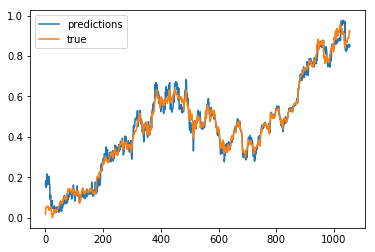

Epoch number: 91
the Loss of the current epoch: tensor(0.1153, device='cuda:0')
Epoch number: 92
the Loss of the current epoch: tensor(1.00000e-02 *
       8.8747, device='cuda:0')
Epoch number: 93
the Loss of the current epoch: tensor(1.00000e-02 *
       9.9612, device='cuda:0')
Epoch number: 94
the Loss of the current epoch: tensor(1.00000e-02 *
       7.5133, device='cuda:0')
Epoch number: 95
the Loss of the current epoch: tensor(1.00000e-02 *
       9.8395, device='cuda:0')
Epoch number: 96
the Loss of the current epoch: tensor(1.00000e-02 *
       9.7947, device='cuda:0')
Epoch number: 97
the Loss of the current epoch: tensor(1.00000e-02 *
       9.4046, device='cuda:0')
Epoch number: 98
the Loss of the current epoch: tensor(1.00000e-02 *
       9.0868, device='cuda:0')
Epoch number: 99
the Loss of the current epoch: tensor(1.00000e-02 *
       8.2397, device='cuda:0')
Epoch number: 100
the Loss of the current epoch: tensor(1.00000e-02 *
       8.9074, device='cuda:0')
Epoch numb

In [67]:
use_cuda = torch.cuda.is_available()

# Parameters
learning_rate = 0.001
batch_size = 16
num_epochs = 120
n_hidden1 = 128
n_hidden2 = 128
display_step = 30


new_data = My_dataset('new_data/train_set.csv')
train_loader = DataLoader(dataset=new_data,
                       batch_size=batch_size,
                       shuffle=False,
                       num_workers=4,
                       pin_memory=True  # CUDA only
                       )

model = LSTM(hidden_size=n_hidden1, hidden_size2=n_hidden2, dropout=0.2, n_layers=4).cuda()
optimizer = optim.RMSprop(model.parameters(), lr=learning_rate, weight_decay=0.0) 
scheduler_model = lr_scheduler.StepLR(optimizer, step_size=1, gamma=1.0)

# loss function
criterion = nn.MSELoss(size_average=True).cuda()

# Store losses
losses = []

for epoch in range(num_epochs):
    loss_ = 0.
    # Store current predictions
    predicted = []
    ground_truth = []
    for data, target in train_loader:

        target = target.float()
        target = target.unsqueeze_(0)
        data = Variable(data.permute(1, 0)).contiguous()
        target = Variable(target.permute(1,0))
        #print target.shape
        if use_cuda:
            data = data.cuda()
            target = target.cuda()
            
        if target.data.size()[0] == batch_size:
                # Set optimizer gradient to 0
                optimizer.zero_grad()
                # Compute predictions
                output = model(data)
                loss = criterion(output, target)
                loss_ += loss.data[0]
                # Backpropagation
                loss.backward()
                # Gradient descent step
                optimizer.step()
                for k in range(batch_size):
                    predicted.append(output.data[k, 0])
                    ground_truth.append(target.data[k,0])
        #break
        
    print 'Epoch number:', epoch
    print 'the Loss of the current epoch:', loss_
    losses.append(loss_)
    scheduler_model.step()
        # Visual check
        # Plot current predictions
    #break
    if epoch % display_step == 0:
        predicted = np.array(predicted).reshape(-1, 1)
        gt = np.array(ground_truth).reshape(-1, 1)
        x = np.array(range(predicted.shape[0]))
        plt.figure()
        plt.plot(x, predicted[:, 0], label="predictions")
        plt.plot(x, gt[:, 0], label="true")
        plt.legend()
        plt.show()


## Plot final value of prediction vs true

In [70]:
predicted = np.array(predicted).reshape(-1, 1)
gt = np.array(ground_truth).reshape(-1, 1)
x = np.array(range(predicted.shape[0]))
trace1 = go.Scatter(
                    x = x,
                    y = predicted[:, 0],
                    mode = "lines",
                    name = "predictions",
                    marker = dict(color = '#17BECF'))

trace2 = go.Scatter(
                    x = x,
                    y = gt[:, 0],
                    mode = "lines",
                    name = "true",
                    marker = dict(color = '#7F7F7F'))
data = [trace1, trace2]
layout = dict(title = 'True vs Predicted - Training')
fig = dict(data = data, layout = layout)
iplot(fig,filename="True vs Predicted - Training")

## Plot training loss vs number of epochs

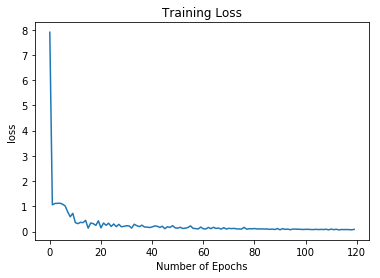

In [82]:
x = np.array(range(num_epochs))
plt.plot(x, losses)
plt.xlabel('Number of Epochs')
plt.ylabel('loss')
plt.title('Training Loss')
plt.show()


## Test

In [72]:
batch_size = 4
new_data = My_dataset('new_data/test_set.csv')
test_loader = DataLoader(new_data,
                             batch_size=batch_size,
                             shuffle=False,
                             num_workers=4,
                             pin_memory=True  # CUDA only
                             )
predictions = []
ground_truth = []

correct = 0
total = 0

for data, target in test_loader:
    target = target.float()
    target = target.unsqueeze_(0)
    data = Variable(data.permute(1, 0)).contiguous()
    target = Variable(target.permute(1,0))
    if use_cuda:
        data = data.cuda()
        target = target.cuda()
    if target.data.size()[0] == batch_size:
        output = model(data)
        for k in range(batch_size):
            predictions.append(output.data[k, 0])
            ground_truth.append(target.data[k, 0])
    #break
    _, pred = torch.max(output.data,1)
    total += target.size(0)
    correct += (pred.float() == target).sum()
    

acc = 100 * correct / total

print 'Accuracy', acc

predicted = np.array(predictions).reshape(-1, 1)
gt = np.array(ground_truth).reshape(-1, 1)
x = np.array(range(predicted.shape[0]))
trace1 = go.Scatter(
                    x = x,
                    y = predicted[:, 0],
                    mode = "lines",
                    name = "predictions",
                    marker = dict(color = '#17BECF'))

trace2 = go.Scatter(
                    x = x,
                    y = gt[:, 0],
                    mode = "lines",
                    name = "true",
                    marker = dict(color = '#7F7F7F'))
data = [trace1, trace2]
layout = dict(title = 'True vs Predicted - Testing')
fig = dict(data = data, layout = layout)
iplot(fig,filename="True vs Predicted - Testing")

Accuracy tensor(4, device='cuda:0')
